# Estimating Causal Effect of Graduate Education on Income

## Import libraries

In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd

import econml
import dowhy
from dowhy import CausalModel

from sklearn.ensemble import RandomForestRegressor

/Users/edison/Git/causality-learning/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
try:
    print(f"[INFO] Using pandas version: {pd.__version__}")
    with open("data/df_causal_inference.p", "rb") as f:
        df = pickle.load(f)
except:
    print("[INFO] Downgrading pandas to 1.5 to load the data...")
    !conda install -q -y pandas=1.5
    with open("data/df_causal_inference.p", "rb") as f:
        df = pickle.load(f)

df.head()

[INFO] Using pandas version: 2.2.3
[INFO] Downgrading pandas to 1.5 to load the data...
Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/edison/Git/causality-learning/venv

  added / updated specs:
    - pandas=1.5


The following packages will be DOWNGRADED:

  pandas                              2.2.3-py310hcf29cfe_0 --> 1.5.3-py310h46d7db6_0 


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


/Users/edison/Git/causality-learning/venv/lib/python3.10/site-packages/IPython/core/formatters.py:406: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/Users/edison/Git/causality-learning/venv/lib/python3.10/site-packages/IPython/core/formatters.py:406: FutureWarning: Int64Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,age,hasGraduateDegree,greaterThan50k
0,39,False,False
1,50,False,False
2,38,False,False
3,53,False,False
5,37,True,False


## Estimating causal effects with `dowhy`

Workflow for estimating causal effects:
1. Collect data
2. Define a causal model (via casual discovery)
3. Identify the statistical estimands
4. Build a model to estimate the causal effects

### 1. Define causal model

In [3]:
model = CausalModel(
    data=df,
    treatment="hasGraduateDegree",
    outcome="greaterThan50k",
    common_causes="age"
)
model

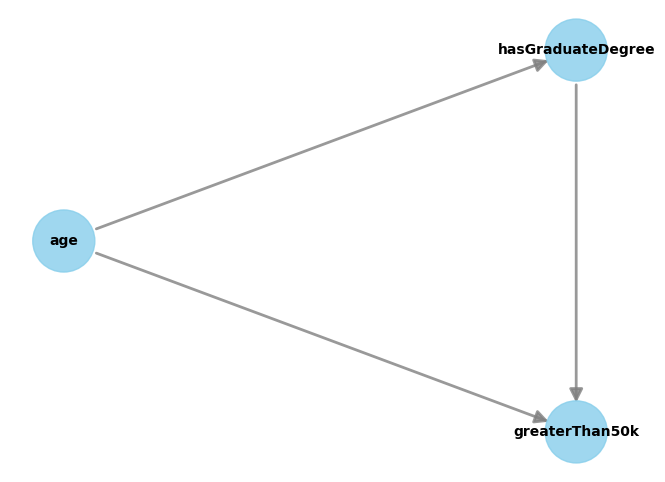

In [4]:
# View the model
model.view_model()

**Note**: The DAG has a fork structure, i.e. `age` (confounder) is a common cause of both the `hasGraduateDegree` (treatment) and `greaterThan50k` (outcome). To compute the causal effect of `hasGraduateDegree` on `greaterThan50k`, we must adjust for `age`.

### 2. Generate a statistical estimand

In step 2., we try to identifiy a statistical estimand from the data with `CausalModel.identify_effect()`. It applies graphical identification rules (e.g. backdoor, frontdoor, etc.) to your causal model to decide whether the causal effect is identifiable from the observational data. If the graphical shortcuts don't work, the library will fall back to full do-calculus or ID algorithm.

In [5]:
# Identify the statistical estimand from data
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                 
────────────────────(E[greaterThan50k|age])
d[hasGraduateDegree]                       
Estimand assumption 1, Unconfoundedness: If U→{hasGraduateDegree} and U→greaterThan50k then P(greaterThan50k|hasGraduateDegree,age,U) = P(greaterThan50k|hasGraduateDegree,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### 3. Estimate the causal effect using meta-learner

After identification, we can estimate the causal effect with `CausalModel.estimate_effect()` with a specified model.

In [6]:
# Estimate the causal effect
metalearner_estimate = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name="backdoor.econml.metalearners.TLearner",
    confidence_intervals=False,
    method_params={
        "init_params":{
            "models": RandomForestRegressor()
        },
        "fit_params": {}
    }
)
print(metalearner_estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                 
────────────────────(E[greaterThan50k|age])
d[hasGraduateDegree]                       
Estimand assumption 1, Unconfoundedness: If U→{hasGraduateDegree} and U→greaterThan50k then P(greaterThan50k|hasGraduateDegree,age,U) = P(greaterThan50k|hasGraduateDegree,age)

## Realized estimand
b: greaterThan50k~hasGraduateDegree+age
Target units: ate

## Estimate
Mean value: 0.20135600438050938
Effect estimates: [[ 0.30374205]
 [ 0.21101982]
 [ 0.33679736]
 ...
 [ 0.15445394]
 [-0.01467145]
 [ 0.1947442 ]]



In [7]:
ite = metalearner_estimate.estimator.effect(df)

print(f"The estimated Average Treatment Effect (ATE): {metalearner_estimate.value}")
print(f"The first 5 estimated Indivial Treatment Effect (ITE): {ite[:5]}")

The estimated Average Treatment Effect (ATE): 0.20135600438050938
The first 5 estimated Indivial Treatment Effect (ITE): [[0.30374205]
 [0.21101982]
 [0.33679736]
 [0.48369778]
 [0.28323353]]


**Note:** The estimated causal effect (ATE) is approx. 0.2. It can be interpeted as: Having a graduate degree will increase the chance of getting more 50k income by 20%. However, ATE is only a good estimate when it follows a Guassian distribution, therefore we need to inspect its empirical distribution.

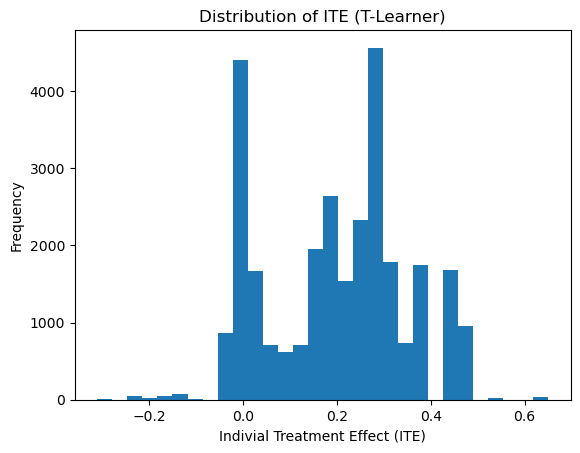

In [8]:
# Plot the histogram of causal effects for each sample
plt.hist(ite,
         bins=30)
plt.xlabel("Indivial Treatment Effect (ITE)")
plt.ylabel("Frequency")
plt.title("Distribution of ITE (T-Learner)")
plt.show();

**Note:** The distribution of ITE has multiple modes (there is a mode around 0.0), in other words, it doesn't follow the normal distribution. Therefore, the estimated ATE might not be a good estimate in this case. Further investigation is necessary on those samples with ATE around 0.0.